# Laboratorium 3 (4 pkt.)

Celem trzeciego laboratorium jest zapoznanie się oraz zaimplementowanie algorytmów uczenia aktywnego. Zaimplementowane algorytmy będą testowane z wykorzystaniem wcześniej przygotowanych środowisk.


Dołączenie standardowych bibliotek

In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np

Dołączenie bibliotek ze środowiskami

In [6]:
from env.dqnSimpleMDP import dqnSimpleMDP
from env.CliffWorldMDP import CliffWorld


## Zadanie 1 - SARSA($\lambda$) (1 pkt.)

<p style='text-align: justify;'>
Celem ćwiczenie jest zaimplementowanie algorytmu SARSA($\lambda$). Algorytm aktualizuje funkcję wartości stanu-akcji dla każdej odwiedzonej pary stan-akcja zgodnie ze wzorem:
\begin{equation}
    Q_{t + 1}(s, a) = Q_t(s, a) + \alpha \delta_t E_t(s, a)
\end{equation}
gdzie:
    
- $\delta_t = r_{t + 1} \gamma Q_t(s_{t + 1}, a_{t + 1}) - Q_t(s_{t}, a_{t})$,
    
- $E_t(s, a)$ - ślad dla pary stan - akcja w chwili czasowej $t$, zwiększany o $1$ w chwili odwiedzenia danego stanu.

</p>

In [13]:
import random
from collections import defaultdict


class SARSALambdaAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions, lambda_value):
        """
        SARSA Lambda Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self._evalues = defaultdict(lambda: defaultdict(lambda: 0))
        self._visited_state_actions = []
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount
        self.lambda_value = lambda_value

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    def reset(self):
        self._evalues = defaultdict(lambda: defaultdict(lambda: 0))
        self._visited_state_actions = []

    # ---------------------START OF YOUR CODE---------------------#
    def get_evalue(self, state, action):
        """ Returns E(state,action) """
        return self._evalues[state][action]

    def set_evalue(self, state, action, value):
        """ Sets the Evalue for [state,action] to the given value """
        self._evalues[state][action] = value

    def update(self, state, action, reward, next_state):
        """
        You should do your SARSA-Lambda update here:
        """

        # agent parameters
        gamma = self.discount

        #
        # INSERT CODE HERE to update value in the state for the action 
        #
        next_action = self.get_action(next_state)

        delta = reward + gamma * self.get_qvalue(next_state, next_action) - self.get_qvalue(state, action)
        self._update_current_state_action_trace(state, action)
        self._update_past_state_actions(delta)

        return next_action

    def _update_current_state_action_trace(self, state, action):
        current_value = self.get_evalue(state, action)
        new_value = current_value + 1
        self.set_evalue(state, action, new_value)
        self._visited_state_actions.append((state, action))

    def _update_past_state_actions(self, delta):
        for state, action in self._visited_state_actions:
            e_value = self.get_evalue(state, action)
            q_value = self.get_qvalue(state, action)
            new_qvalue = q_value + self.alpha * delta * e_value
            new_evalue = self.discount * self.alpha * e_value

            self.set_qvalue(state, action, new_qvalue)
            self.set_evalue(state, action, new_evalue)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #
        # INSERT CODE HERE to get best action for a given state
        #
        #
        qvalues = [self.get_qvalue(state, action) for action in possible_actions]
        best_qvalue = max(qvalues)
        best_actions = [action for action, qvalue in zip(possible_actions, qvalues) if qvalue == best_qvalue]
        best_action = random.choice(best_actions)

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list).
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        #
        # INSERT CODE HERE to get action in a given state (according to epsilon greedy algorithm)
        #
        should_random = random.random() < epsilon

        if should_random:
            chosen_action = random.choice(possible_actions)
        else:
            return self.get_best_action(state)

        return chosen_action

    def turn_off_learning(self):
        self.epsilon = 0
        self.alpha = 0

    def display_qvalues(self):
        for s in self._qvalues:
            print("State: " + str(s) + " " + str(self._qvalues[s]))


 Czas nauczyć agenta poruszania się po dowolnym środowisku:

In [14]:
def play_and_train(env, agent):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    state = env.reset()

    agent.reset()

    done = False
    action = agent.get_action(state)

    while not done:
        # get agent to pick action given state state.

        next_state, reward, done, _ = env.step(action)

        # train (update) agent for state
        action = agent.update(state, action, reward, next_state)

        state = next_state
        total_reward += reward
        if done:
            break
    return total_reward

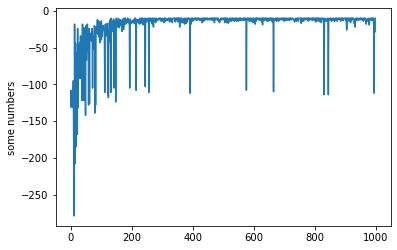

In [15]:
environment = CliffWorld()
agent = SARSALambdaAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                   get_legal_actions=environment.get_possible_actions, lambda_value = 0.5)

rewards = []
for i in range(1000):
    rewards.append(play_and_train(environment, agent))

plt.plot(rewards)
plt.ylabel('some numbers')
plt.show()

## Zadanie 2 - Double Q-Learning

<p style='text-align: justify;'>
Celem ćwiczenie jest zaimplementowanie algorytmu Double Q-Learning. Algorytm aktualizuje funkcję wartości stanu-akcji zgodnie ze wzorami:
    \begin{equation*}
        Q_1(s_t, a_t) = Q_1(s_t, a_t) + \alpha[r_{t+1} + \gamma Q_2(s_{t + 1}, argmax_a(Q_1(s_{t + 1}, a))) - Q_1(s_t, a_t)]
    \end{equation*}
    \begin{equation*}
        Q_2(s_t, a_t) = Q_2(s_t, a_t) + \alpha[r_{t+1} + \gamma Q_1(s_{t + 1}, argmax_a(Q_2(s_{t + 1}, a))) - Q_2(s_t, a_t)]
    \end{equation*}
z prawdopodobieństwem wyboru każdej z opcji równym 50%.
</p>

In [ ]:
import random
from collections import defaultdict


class DQLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Double Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)
        """

        self.get_legal_actions = get_legal_actions
        self._qvaluesA = defaultdict(lambda: defaultdict(lambda: 0))
        self._qvaluesB = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount
        
    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvaluesA[state][action] + self._qvaluesB[state][action] 


    #---------------------START OF YOUR CODE---------------------#

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        #
        # INSERT CODE HERE to update value in the state for the action 
        #


    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list).
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        #
        # INSERT CODE HERE to get action in a given state (according to epsilon greedy algorithm)
        #        

        return chosen_action

    def turn_off_learning(self):
        self.epsilon = 0
        self.alpha = 0


In [ ]:
env = dqnSimpleMDP()

max_tests = 10000
n_eps = 300
eps = 0.1
lr = 0.1


left_count_q = np.zeros(n_eps) #count left choices in state A for algorithm Q-Learning
left_count_dq = np.zeros(n_eps) #count left choices in state A for algorithm Double Q-Learning

q_estimate = np.zeros(n_eps) #store value estimation for choosing action left in left choices in state A for algorithm Q-Learning
dq_estimate = np.zeros(n_eps) #store value estimation for choosing action left in left choices in state A for algorithm Double Q-Learning

t = 0
while t < max_tests:

    agent = QLearningAgent(alpha=0.1, epsilon=0.1, discount=1,
                           get_legal_actions=env.get_possible_actions)
    for ep in range(n_eps):
        state = env.reset()
        while True:
            # Select eps-greedy action
            action = agent.get_action(state)

            # Count left actions from A
            if state == 'A' and action == 1:
                left_count_q[ep] += 1

            next_state, reward, done, _ = env.step(action)

            agent.update(state, action, reward, next_state)

            state = next_state
            if done:
                q_estimate[ep] += agent.get_qvalue('A', 1)

                break
    t += 1

q_estimate /= max_tests

In [ ]:
t = 0
while t < max_tests:

    agent = DQLearningAgent(alpha=0.1, epsilon=0.1, discount=1,
                            get_legal_actions=env.get_possible_actions)
    for ep in range(n_eps):
        state = env.reset()
        while True:
            # Select eps-greedy action
            action = agent.get_action(state)

            # Count left actions from A
            if state == 'A' and action == 1:
                left_count_dq[ep] += 1

            next_state, reward, done, _ = env.step(action)

            agent.update(state, action, reward, next_state)

            state = next_state
            if done:
                dq_estimate[ep] += agent.get_qvalue('A', 1) / 2

                break
    t += 1

dq_estimate /= max_tests

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(left_count_q/max_tests*100,
         label='Q-Learning')
plt.plot(left_count_dq/max_tests*100,
         label='Double Q-Learning')
plt.ylabel('Percentage of Left Actions')
plt.xlabel('Episodes')
plt.title(r'Q-Learning Action Selection ($\epsilon=0.1$)')
plt.legend(loc='best')
plt.show()




In [ ]:
plt.figure(figsize=(12,8))
plt.plot(q_estimate, label='Q-Learning')
plt.plot(dq_estimate, label='Double Q-Learning')

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Estimated Value')
plt.title('Estimated Value of Choosing Left from State A')
plt.show()

## Zadanie 3 

Przetestuj działanie wszystkich zaimplementowanych algorytmów w środowisku dqnSimpleMDP, który algorytm działa najlepiej?